# Testing out the Chesscog Library
https://github.com/georg-wolflein/chesscog

In [1]:
import chesscog
from chesscog.recognition import ChessRecognizer
import cv2
import matplotlib.pyplot as plt
from recap import URI

import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
import chess

%load_ext lab_black

[2022-09-14 00:02:49,600] {<frozen importlib._bootstrap>:219} INFO - Generating grammar tables from /home/robmulla/.local/lib/python3.8/site-packages/blib2to3/Grammar.txt
[2022-09-14 00:02:49,613] {<frozen importlib._bootstrap>:219} INFO - Writing grammar tables to /home/robmulla/.cache/black/22.1.0/Grammar3.8.12.final.0.pickle
[2022-09-14 00:02:49,615] {<frozen importlib._bootstrap>:219} INFO - Writing failed: [Errno 2] No such file or directory: '/home/robmulla/.cache/black/22.1.0/tmp6e7twonc'
[2022-09-14 00:02:49,616] {<frozen importlib._bootstrap>:219} INFO - Generating grammar tables from /home/robmulla/.local/lib/python3.8/site-packages/blib2to3/PatternGrammar.txt
[2022-09-14 00:02:49,618] {<frozen importlib._bootstrap>:219} INFO - Writing grammar tables to /home/robmulla/.cache/black/22.1.0/PatternGrammar3.8.12.final.0.pickle
[2022-09-14 00:02:49,619] {<frozen importlib._bootstrap>:219} INFO - Writing failed: [Errno 2] No such file or directory: '/home/robmulla/.cache/black/22.1

In [31]:
def get_img_class(cap):
    ret, img = cap.read()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    classifiers_folder = URI("/home/robmulla/Repos/chesscog/models/")
    recognizer = ChessRecognizer(classifiers_folder)
    board, *_ = recognizer.predict(
        img,
    )
    return img, board


def plot_img(img):
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(img[:, :, :])
    ax.axis("off")
    plt.show()


def create_joint_df(gt_board, pred_board):
    gt_df = pd.DataFrame().from_dict(gt_board.piece_map(), orient="index")
    pred_df = pd.DataFrame().from_dict(pred_board.piece_map(), orient="index")

    skel = pd.DataFrame(index=range(64))

    df = skel.merge(
        gt_df.merge(
            pred_df,
            left_index=True,
            right_index=True,
            suffixes=("_gt", "_pred"),
            how="outer",
        ),
        left_index=True,
        right_index=True,
        how="outer",
    ).fillna(0)

    df.loc[df["color_gt"] == False, "piece_type_gt"] *= -1
    df.loc[df["color_pred"] == False, "piece_type_pred"] *= -1

    return df[["piece_type_gt", "piece_type_pred"]].astype("int")


def get_score(gt_board, board, weight=None):
    df = create_joint_df(gt_board, board)
    if weight:
        weight = (np.clip(np.abs(df["piece_type_gt"]), 0, 1) + 1) * 2
    score = accuracy_score(
        df["piece_type_gt"], df["piece_type_pred"], sample_weight=weight
    )
    return score


PIECES = [".", "p", "P", "n", "N", "b", "B", "r", "R", "q", "Q", "k", "K"]


def onehot_board(board_str):
    board = np.zeros(shape=(13, 8, 8))
    for r, row in enumerate(board_str.split("\n")):
        for c, piece in enumerate(row.split()):
            board[PIECES.index(piece), r, c] = 1

    return board


def MSELoss(a, b):
    return ((a - b) ** 2).mean(axis=0).sum()


def MSEBoard(board1, board2):
    b1_encoded = onehot_board(str(board1))
    b2_encoded = onehot_board(str(board2))
    return MSELoss(b1_encoded, b2_encoded) / 9.84

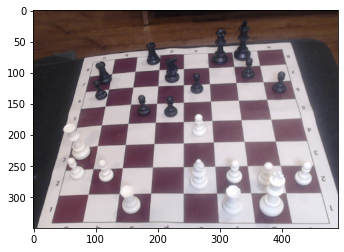

In [32]:
plt.imshow(img[50:400, 150:, :])

Accuracy Score: 0.8125
MSE Score: 0.1876
Prediction

n n n r q n n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. P . P . P . P
R N B Q Q Q R R

Ground Truth

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


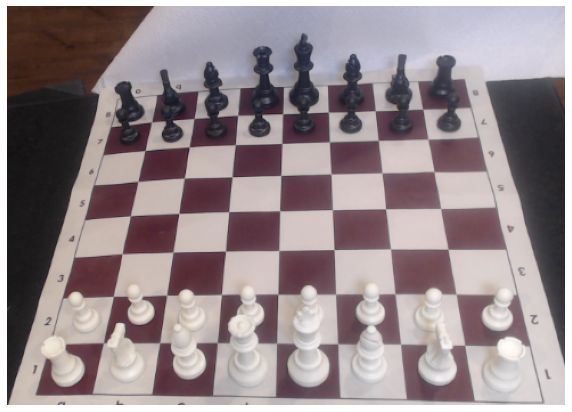

In [44]:
cap.release()
cap = cv2.VideoCapture(5)
img, board = get_img_class(cap)
img = img[50:400, 150:, :]
# gt_board = chess.Board("2r2qk1/r2n2p1/p3p2p/2pp4/4P3/Q7/PP2BPPP/2R2RK1")
gt_board = chess.Board("rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1")
score = get_score(gt_board, board)
mse = MSEBoard(gt_board, board)
print(f"Accuracy Score: {score:0.4}")
print(f"MSE Score: {mse:0.4}")


print("Prediction")
print("")
print(board)
print("")
print("Ground Truth")
print("")
print(gt_board)


plot_img(img)

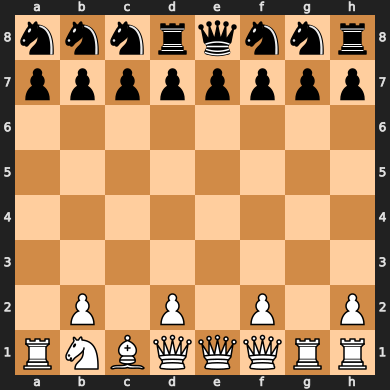

In [45]:
board

# Score Metric?

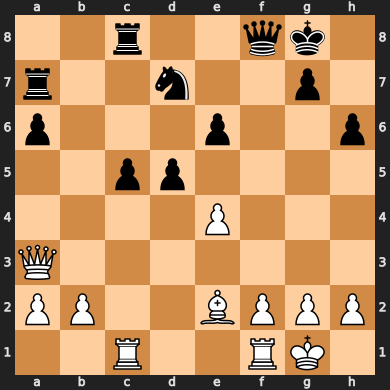

In [7]:
gt_board = chess.Board("2r2qk1/r2n2p1/p3p2p/2pp4/4P3/Q7/PP2BPPP/2R2RK1")
gt_board

In [8]:
gt_board.piece_type_at(5)

4

In [95]:
print(classification_report(df["piece_type_gt"], df["piece_type_pred"]))

              precision    recall  f1-score   support

          -6       0.00      0.00      0.00         1
          -5       0.00      0.00      0.00         1
          -4       1.00      0.50      0.67         2
          -2       0.33      1.00      0.50         1
          -1       1.00      1.00      1.00         6
           0       0.91      1.00      0.95        42
           1       1.00      0.50      0.67         6
           3       0.00      0.00      0.00         1
           4       1.00      1.00      1.00         2
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1

    accuracy                           0.86        64
   macro avg       0.48      0.45      0.44        64
weighted avg       0.85      0.86      0.84        64



/home/robmulla/anaconda3/envs/chessviz/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/robmulla/anaconda3/envs/chessviz/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/robmulla/anaconda3/envs/chessviz/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [97]:
get_score(gt_board, board)

0.7906976744186046

# MSE Loss

In [105]:
MSEBoard(gt_board, board)

1.3846153846153846